# Leaf tracking, in a time-series of 3D segmented maize plants

#### Corresponding article in Plant Methods (Daviet et al. 2022) : https://doi.org/10.1186/s13007-022-00961-4)

#### 3D segmentations were obtained with Phenomenal (https://github.com/openalea/phenomenal)

#### In this notebook, 3D visualisations are made with matplotlib. Other tools could be used for more advanced visualisations such as openalea.plantgl (https://github.com/openalea/plantgl)

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import openalea.phenomenal.object.voxelSegmentation as phm_seg

from openalea.maizetrack.trackedPlant import TrackedPlant
from openalea.maizetrack.display import PALETTE
from openalea.maizetrack.phenomenal_coupling import phm_to_phenotrack_input
from openalea.maizetrack.polyline_utils import polyline_length

from datadir import datadir

In [2]:
def plot3d(polylines, ranks):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')
    plt.axis('off')
    for pl, rank in zip(polylines, ranks):
        color = PALETTE[int(rank - 1)]/255. if rank > 0 else np.array([80, 80, 80])/255.
        linestyle = '-' if rank > 0 else '--'
        ax.plot(pl[:, 0], pl[:, 1], zs=pl[:, 2], color=color, linewidth=0.7, linestyle=linestyle)

# 1 - Data Preparation

## Load a time-series of segmented plant (from Phenomenal)

In [3]:
fd = datadir + '/3d_time_series'
phm_segs, timestamps = [], []
for filename in os.listdir(fd):
    timestamps.append(int(filename.split('.gz')[0]))
    phm_segs.append(phm_seg.VoxelSegmentation.read_from_json_gz(os.path.join(fd, filename)))

## Conversion to a generic format

In [4]:
phenotrack_segs, checks_stem = phm_to_phenotrack_input(phm_segs, timestamps)

print(f'{len(phm_segs) - len(phenotrack_segs)} time-step was removed due to an abnormal stem shape')

1 time-step was removed due to an abnormal stem shape


<IPython.core.display.Javascript object>


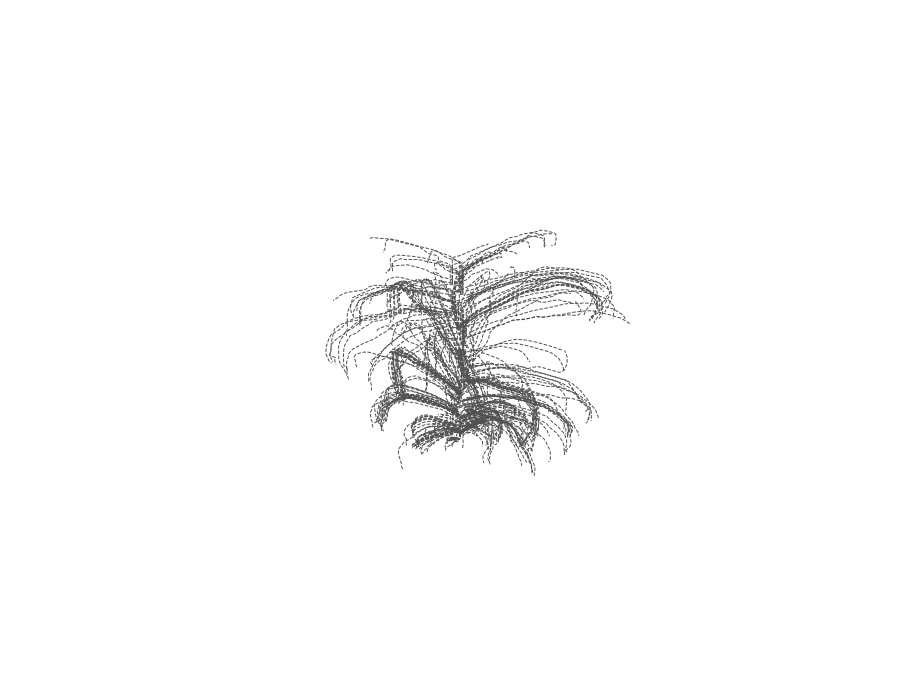

In [5]:
polylines = [pl for seg in phenotrack_segs for pl in seg['polylines_sequence']]
plot3d(polylines, [-1] * len(polylines))

In [6]:
trackedplant = TrackedPlant.load(phenotrack_segs)

## Explain format
## example of a mature leaf and a growing leaf

# 2 - Tracking of mature leaves

# Before

<IPython.core.display.Javascript object>


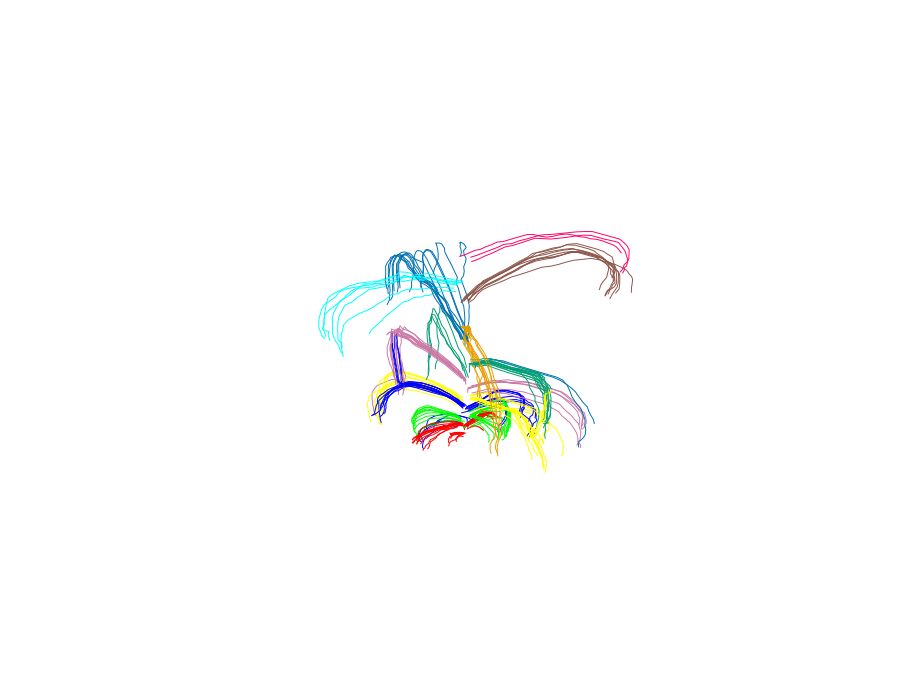

In [7]:
raw_ranks = [r + 1 for s in trackedplant.snapshots for r, l in enumerate(s.leaves) if l.features['mature']]
polylines = [l.polyline for s in trackedplant.snapshots for l in s.leaves if l.features['mature']]
plot3d(polylines, raw_ranks)

# After

In [8]:
trackedplant.mature_leaf_tracking(start=0, # which time step is used to initialize tracking
                                  gap=12, # gap penalty parameter
                                  w_h=0.03, # importance weight for leaf height feature
                                  w_l=0.004, # importance weight for leaf length feature
                                  gap_extremity_factor=0.2, # weight applied to the gap penalty on sequence extremities
                                  align_range=None # maximum distance between two time-steps so that thet can be compared (inf if None)
                                 )

# trackedplant.mature_leaf_tracking(start=-1, gap=2.5, w_h=0.02, w_l=0.004, gap_extremity_factor=0.8, align_range=None)

<IPython.core.display.Javascript object>


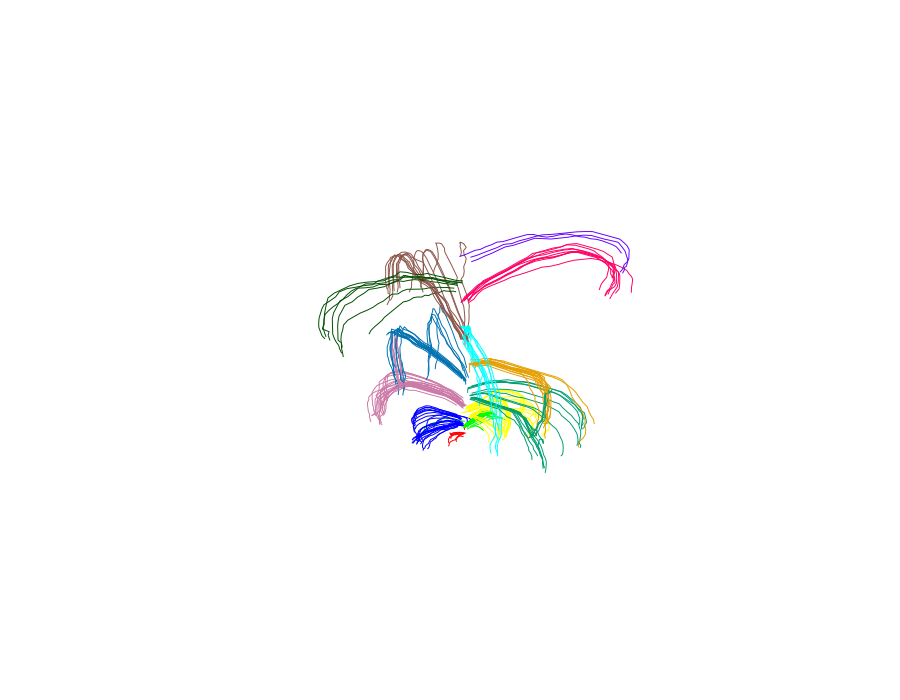

In [9]:
ranks = [r for s in trackedplant.snapshots for l, r in zip(s.leaves, s.leaf_ranks()) if l.features['mature']]
polylines = [l.polyline for s in trackedplant.snapshots for l in s.leaves if l.features['mature']]
plot3d(polylines, ranks)

# 3 - Tracking of growing leaves

In [10]:
trackedplant.growing_leaf_tracking()

<IPython.core.display.Javascript object>


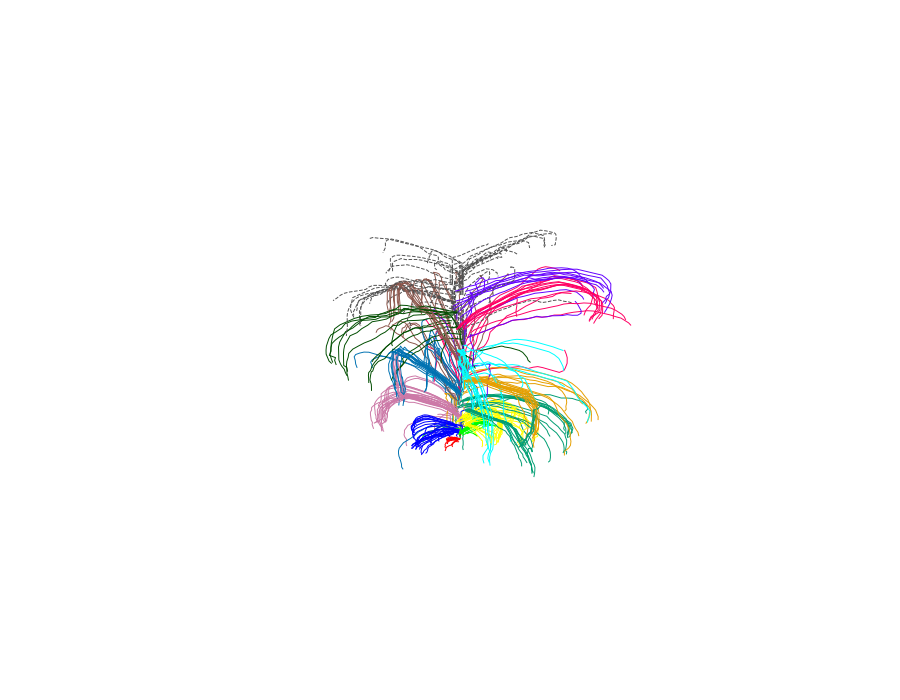

In [11]:
ranks = [r for s in trackedplant.snapshots for l, r in zip(s.leaves, s.leaf_ranks())]
polylines = [l.polyline for s in trackedplant.snapshots for l in s.leaves]
plot3d(polylines, ranks)

# Tell about annotation (put image)

# Traits

In [12]:
df = []
for snapshot, time in zip(trackedplant.snapshots, np.array(timestamps)[checks_stem]):
    for rank, leaf in zip(snapshot.leaf_ranks(), snapshot.leaves):
        length = polyline_length(leaf.polyline)
        df.append([time, rank, length, leaf.features['mature']])
df = pd.DataFrame(df, columns=['time', 'rank', 'length', 'mature'])
df['time'] = (df['time'] - np.min(df['time'])) / 3600 / 24

# Needs only Mature

<IPython.core.display.Javascript object>


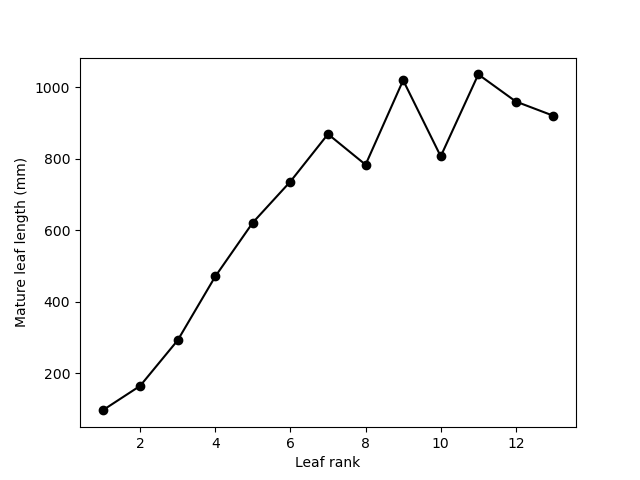

Text(0, 0.5, 'Mature leaf length (mm)')

In [14]:
t_max = 20 # time after leaf emergence when a mature leaf is not considered anymore (days)

ranks = sorted([r for r in df['rank'].unique() if r > 0])
lengths = []
for rank in ranks:
    s = df[(df['rank'] == rank) & (df['mature'])]
    s = s[s['time'] < np.min(s['time']) + t_max]
    lengths.append(np.median(s['length']))

plt.figure()
plt.plot(ranks, lengths, 'k-o')
plt.xlabel('Leaf rank')
plt.ylabel('Mature leaf length (mm)')

# Needs growing, less accurate

<IPython.core.display.Javascript object>


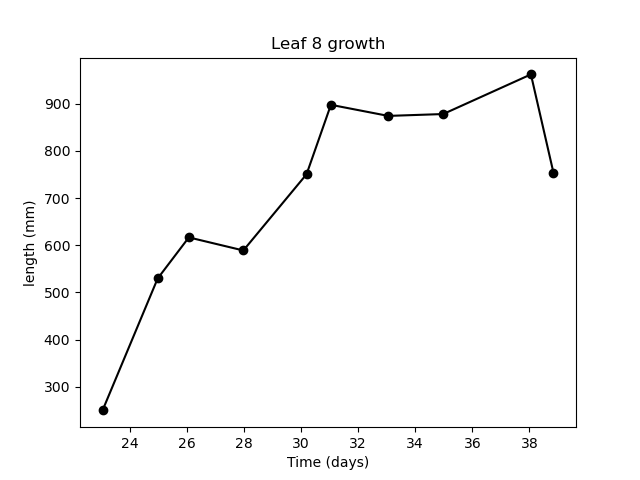

In [15]:
rank = 8

s = df[(df['rank'] == rank) & (~df['mature'])].sort_values('time')

plt.figure()
plt.title('Leaf 8 growth')
plt.xlabel('Time (days)')
plt.ylabel('length (mm)')
plt.plot(s['time'], s['length'], 'k-o')

In [16]:
trackedplant.output()

([[1],
  [1, 2],
  [1, 3, 2],
  [1, 3, 2],
  [1, 2, 3],
  [1, 2, 3, 4],
  [1, 3, 2],
  [1, 2, 3, 4, 5],
  [1, 2, 3, 4, 6, 5],
  [1, 2, 4, 6, 5, 3],
  [1, 2, 3, 4, 5, 6],
  [1, 2, 3, 4, 7, 5, 6],
  [1, 2, 3, 4, 5, 6, 7],
  [1, 2, 3, 4, 5, 6, 8, 7],
  [1, 2, 3, 4, 5, 6, 8, 7, 9],
  [2, 3, 4, 5, 6, 7, 8],
  [2, 3, 4, 5, 6, 8, 7, 10, 9],
  [2, 3, 4, 5, 6, 8, 11, 10, 9, 7],
  [2, 3, 4, 5, 6, 11, 8, 10, 7, 9],
  [2, 3, 4, 5, 6, 8, 10, 9, 7, 11],
  [2, 3, 4, 5, 6, 11, 8, 10, 7, 9],
  [2, 3, 4, 5, 6, 7, 9, 8, 11, 12, 10],
  [2, 3, 4, 5, 6, 7, 8, 12, 11, 10, 9, 13],
  [2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 10, 12],
  [2, 3, 4, 5, 6, 7, 8, 10, 9, 12, 11, 13],
  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
  [3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 13, 0, 0, 12],
  [3, 4, 5, 6, 7, 8, 9, 10, 12, 11, 0, 0, 13, 0],
  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0],
  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0, 0],
  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0, 0],
  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 0],
  [3, 4, 5, 6

In [17]:
checks_stem

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [18]:
len(phenotrack_segs)

38

In [19]:
len(phm_segs)

39